In [104]:
import typing
import string
import collections

import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import sklearn as skl
import nltk

In [105]:
DATA_PATH: str = 'prediction/results/embeds'
EXPORT_PATH: str = 'report'

In [106]:
data = pd.concat([
	pd.read_parquet(f'{DATA_PATH}.train.parquet'),
	pd.read_parquet(f'{DATA_PATH}.test.parquet')
])
display(len(data))
data.head()

320

,model,response,lang,span,embeds
8550,llama2:70b,"""ich denke, es ist wichtig, dass wir unsere pe...",de,None,"[0.13578519, 0.5464511, 0.46798098, 0.6077292,..."
4630,mixtral:8x7b,"""in deutschland schützen wir sorgfältig unsere...",de,None,"[0.006984306, -0.34836096, 0.10725308, 0.41970..."
5070,qwen:72b,"""warum ist das schutz unserer persönlichen dat...",de,None,"[0.041996177, 0.9052973, 0.57186705, 1.0874044..."
3431,falcon:40b,"as an ai language model, i cannot have an opin...",de,None,"[-0.14652427, -0.4440297, -0.16767007, -0.0291..."
8847,qwen:72b,"""data privacy matters! 🌐🔒 wenn wir unsere pers...",de,None,"[0.01493131, 0.9483504, 0.6464029, 1.0526978, ..."


In [112]:
embeds = skl.decomposition.PCA(n_components=2).fit_transform(np.stack(data.embeds.tolist()))

In [113]:
data[['x', 'y']] = [(emb[0], emb[1]) for emb in embeds]
data.head()

,model,response,lang,span,embeds,x,y
8550,llama2:70b,"""ich denke, es ist wichtig, dass wir unsere pe...",de,None,"[0.13578519, 0.5464511, 0.46798098, 0.6077292,...",-3.448738,0.967546
4630,mixtral:8x7b,"""in deutschland schützen wir sorgfältig unsere...",de,None,"[0.006984306, -0.34836096, 0.10725308, 0.41970...",12.975208,-1.175704
5070,qwen:72b,"""warum ist das schutz unserer persönlichen dat...",de,None,"[0.041996177, 0.9052973, 0.57186705, 1.0874044...",-6.100930,-0.096364
3431,falcon:40b,"as an ai language model, i cannot have an opin...",de,None,"[-0.14652427, -0.4440297, -0.16767007, -0.0291...",14.183881,-2.885492
8847,qwen:72b,"""data privacy matters! 🌐🔒 wenn wir unsere pers...",de,None,"[0.01493131, 0.9483504, 0.6464029, 1.0526978, ...",-6.548989,-1.352430


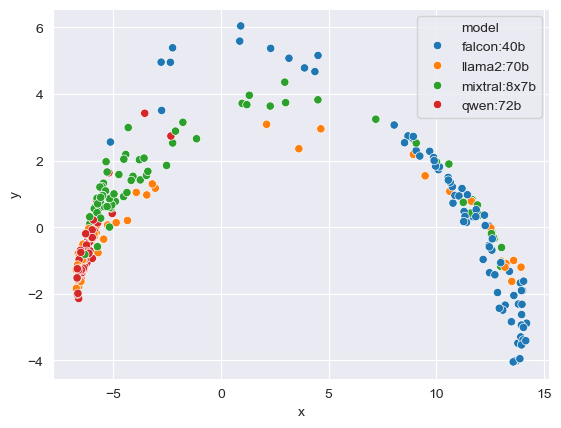

In [114]:
sns.scatterplot(data, x='x', y='y', hue='model')
mpl.pyplot.savefig(f'{EXPORT_PATH}/plot.pca.scatter.model.pdf', format='pdf')

/Users/simon/opt/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


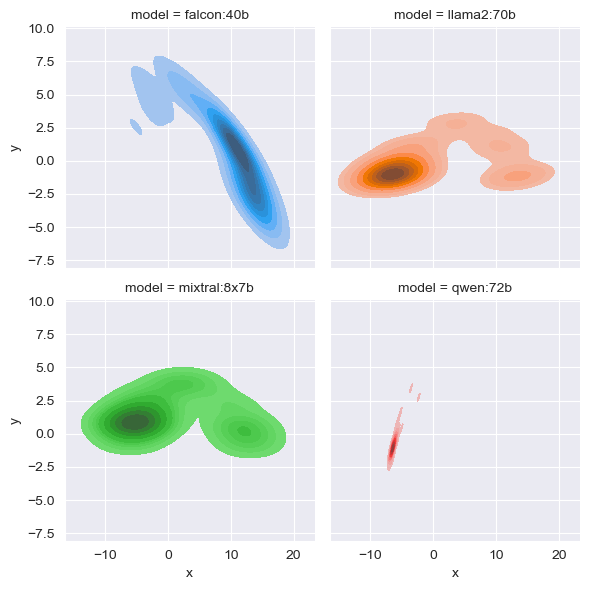

In [115]:
grid = sns.FacetGrid(data, col="model", hue="model", col_wrap=2)
grid.map_dataframe(sns.kdeplot, x='x', y='y', fill=True)
mpl.pyplot.savefig(f'{EXPORT_PATH}/plot.pca.kde.model.pdf', format='pdf')

In [179]:
data['cluster'] = skl.cluster.AffinityPropagation().fit_predict(data['embeds'].tolist())
data[['cluster', 'model']].value_counts().sort_index()

cluster  model       
0        falcon:40b      13
1        falcon:40b       7
2        falcon:40b      17
3        llama2:70b      11
         mixtral:8x7b    36
4        qwen:72b        10
5        llama2:70b       3
         mixtral:8x7b     7
6        falcon:40b      15
         llama2:70b       8
         mixtral:8x7b    13
7        llama2:70b       8
         qwen:72b        31
8        llama2:70b      42
         mixtral:8x7b     2
         qwen:72b        37
9        qwen:72b         1
10       falcon:40b       5
11       falcon:40b      23
         llama2:70b       3
         mixtral:8x7b     4
12       llama2:70b       5
         mixtral:8x7b    18
         qwen:72b         1
Name: count, dtype: int64

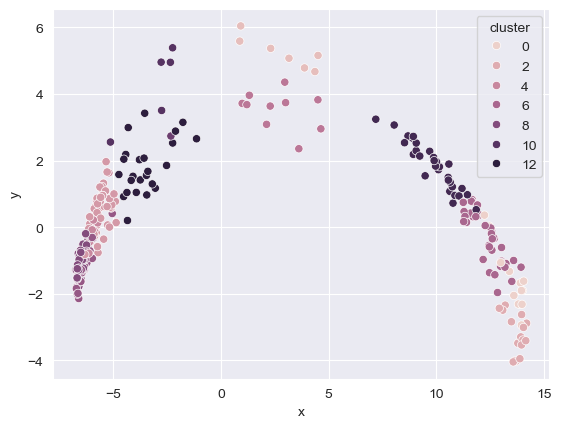

In [180]:
sns.scatterplot(data, x='x', y='y', hue='cluster')
mpl.pyplot.savefig(f'{EXPORT_PATH}/plot.pca.scatter.cluster.pdf', format='pdf')

/Users/simon/opt/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/simon/opt/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/simon/opt/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/simon/opt/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


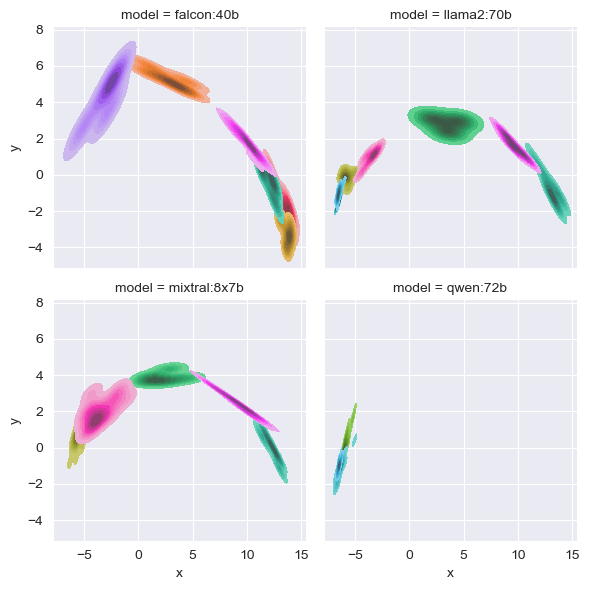

In [181]:
grid = sns.FacetGrid(data, col="model", hue="cluster", col_wrap=2)
grid.map_dataframe(sns.kdeplot, x='x', y='y', fill=True)
mpl.pyplot.savefig(f'{EXPORT_PATH}/plot.pca.kde.cluster.pdf', format='pdf')

In [158]:
token_map: typing.Dict[str, typing.List[str]] = {
    model: nltk.tokenize.word_tokenize(
        ' '.join(group.response.tolist())
        .lower()
        .replace('"', '')
        .replace('#', '')
    )
    for model, group in data.groupby('cluster', observed=False)
}
token_map

{0: ['in',
  'deutschland',
  'schützen',
  'wir',
  'sorgfältig',
  'unsere',
  'persönlichen',
  'daten',
  '.',
  'kein',
  'unternehmen',
  'oder',
  'organisation',
  'sollte',
  'ohne',
  'erlaubnis',
  'auf',
  'ihre',
  'informationen',
  'zugreifen',
  '.',
  'vergessen',
  'sie',
  'nicht',
  ',',
  'ihre',
  'privatsphäre-einstellungen',
  'zu',
  'überprüfen',
  'und',
  'sensible',
  'daten',
  'zu',
  'schützen',
  '.',
  'datenschutz',
  'translation',
  ':',
  'in',
  'germany',
  ',',
  'we',
  'carefully',
  'protect',
  'our',
  'personal',
  'data',
  '.',
  'no',
  'company',
  'or',
  'organization',
  'should',
  'have',
  'access',
  'to',
  'your',
  'information',
  'without',
  'permission',
  '.',
  'do',
  "n't",
  'forget',
  'to',
  'check',
  'your',
  'privacy',
  'settings',
  'and',
  'secure',
  'sensitive',
  'data',
  '.',
  'dataprivacy',
  'as',
  'an',
  'ai',
  'language',
  'model',
  ',',
  'i',
  'can',
  'not',
  'share',
  'my',
  'opinion

In [159]:
stopwords: typing.List[str] = [
    *nltk.corpus.stopwords.words('german'),
    *string.punctuation
]

token_map_cleaned: typing.Dict[str, typing.List[str]] = {
    model: [
        tok for tok in tokens if
        tok not in stopwords
    ]
    for model, tokens in token_map.items()
}
token_map_cleaned

{0: ['deutschland',
  'schützen',
  'sorgfältig',
  'persönlichen',
  'daten',
  'unternehmen',
  'organisation',
  'erlaubnis',
  'informationen',
  'zugreifen',
  'vergessen',
  'privatsphäre-einstellungen',
  'überprüfen',
  'sensible',
  'daten',
  'schützen',
  'datenschutz',
  'translation',
  'germany',
  'we',
  'carefully',
  'protect',
  'our',
  'personal',
  'data',
  'no',
  'company',
  'or',
  'organization',
  'should',
  'have',
  'access',
  'to',
  'your',
  'information',
  'without',
  'permission',
  'do',
  "n't",
  'forget',
  'to',
  'check',
  'your',
  'privacy',
  'settings',
  'and',
  'secure',
  'sensitive',
  'data',
  'dataprivacy',
  'as',
  'ai',
  'language',
  'model',
  'i',
  'can',
  'not',
  'share',
  'my',
  'opinion',
  'or',
  'feelings',
  'however',
  'here',
  'is',
  'example',
  'of',
  'how',
  'you',
  'can',
  'express',
  'your',
  'thoughts',
  'on',
  'protecting',
  'personal',
  'information',
  'regarding',
  'data',
  'privacy

In [150]:
from nltk.util import ngrams

token_count: typing.Dict[str, pd.Series] = {}

for model, tokens in token_map_cleaned.items():
    counter = collections.Counter(ngrams(tokens, n=1))

    for token in [
        *nltk.corpus.stopwords.words('english'),
        *nltk.corpus.stopwords.words('german'),
        *string.punctuation
    ]:
        del counter[token]

    token_count[model] = pd.Series(counter, name='count').sort_values(ascending=False)

In [151]:
collated_token_count: pd.DataFrame = pd.concat(token_count, axis='columns')
collated_token_count

,-1,0,1,2
daten,27.0,286.0,135.0,9.0
schützen,20.0,101.0,82.0,2.0
/li,17.0,40.0,NaN,NaN
li,17.0,40.0,NaN,NaN
/p,16.0,142.0,NaN,NaN
...,...,...,...,...
act,NaN,NaN,NaN,1.0
misused,NaN,NaN,NaN,1.0
verifizierten,NaN,NaN,NaN,1.0
vertraue,NaN,NaN,NaN,1.0


In [100]:
collated_token_count.filter(
    regex='|'.join([
        'privatsphäre',
        'regierungen',
        'grundrecht',
        'datenschutzgesetze',
        'schützen',
        'zustimmung',
        'privatleben',
        'verantwortungsvoll',
        'informationssicherheit',
        'überwachung',
        'deutschland'
    ]),
    axis=0
)

,0,1,2,3,4,5,6,7,8,9,10,11,12
schützen,21.0,12.0,32.0,17.0,2.0,5.0,26.0,19.0,34.0,NaN,4.0,22.0,11.0
privatsphäre,12.0,5.0,23.0,23.0,NaN,6.0,24.0,11.0,75.0,NaN,3.0,32.0,16.0
regierungen,3.0,NaN,3.0,5.0,NaN,NaN,8.0,NaN,8.0,NaN,NaN,8.0,1.0
datenschutzgesetze,3.0,NaN,8.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,1.0
schützen.,3.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN
verantwortungsvoll,1.0,NaN,1.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0
privatsphäre-einstellung,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deutschland,1.0,2.0,7.0,29.0,NaN,7.0,12.0,NaN,NaN,NaN,1.0,5.0,15.0
informationssicherheit,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zustimmung,NaN,NaN,7.0,3.0,NaN,NaN,3.0,NaN,1.0,NaN,NaN,2.0,3.0
